In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import scipy

from keras.layers import Dense
from keras.layers import Dropout
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout ,Flatten ,MaxPooling2D

In [ ]:
from google.colab import drive    # Drive 'ı bağlamak için kullanılan komut satırı
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/ColabNotebooks/archiveA/train'  # Veri dizini (eğitim)
TEST_DIR = '/content/drive/MyDrive/YenidenVeri/test'  #Veri dizini (test)
# load_dataset fonksiyonunu tanımlayın
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(os.path.join(directory, label)):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
        print(label, "Completed")

    return image_paths, labels

# Veri setini yükle ve DataFrame oluştur
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)

# Veriyi karıştır ve indeksi sıfırla
train = train.sample(frac=1).reset_index(drop=True)
train.head()


disgusted Completed
neutral Completed
happy Completed
angry Completed
fearful Completed
surprised Completed
sad Completed


,image,label
0,/content/drive/MyDrive/ColabNotebooks/archiveA...,fearful
1,/content/drive/MyDrive/ColabNotebooks/archiveA...,sad
2,/content/drive/MyDrive/ColabNotebooks/archiveA...,angry
3,/content/drive/MyDrive/ColabNotebooks/archiveA...,angry
4,/content/drive/MyDrive/ColabNotebooks/archiveA...,neutral


In [ ]:
test = pd.DataFrame() # test veri setini yükleme
test["image"],test["label"] = load_dataset(TEST_DIR)
test = test.sample(frac=1).reset_index(drop=True)
test.head()



angry Completed
disgusted Completed
fearful Completed
happy Completed
neutral Completed
sad Completed
surprised Completed


,image,label
0,/content/drive/MyDrive/YenidenVeri/test/surpri...,surprised
1,/content/drive/MyDrive/YenidenVeri/test/sad/İ...,sad
2,/content/drive/MyDrive/YenidenVeri/test/sad/İ...,sad
3,/content/drive/MyDrive/YenidenVeri/test/fearfu...,fearful
4,/content/drive/MyDrive/YenidenVeri/test/happy/...,happy


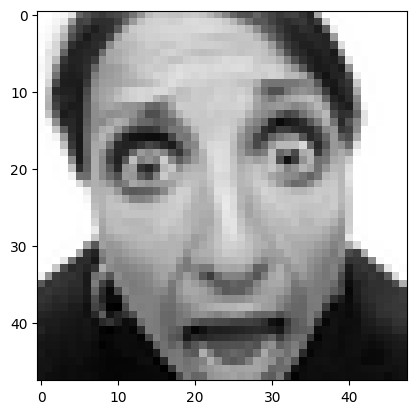

In [ ]:
from PIL import Image
img = Image.open(train["image"][0])
plt.imshow(img,cmap="gray");

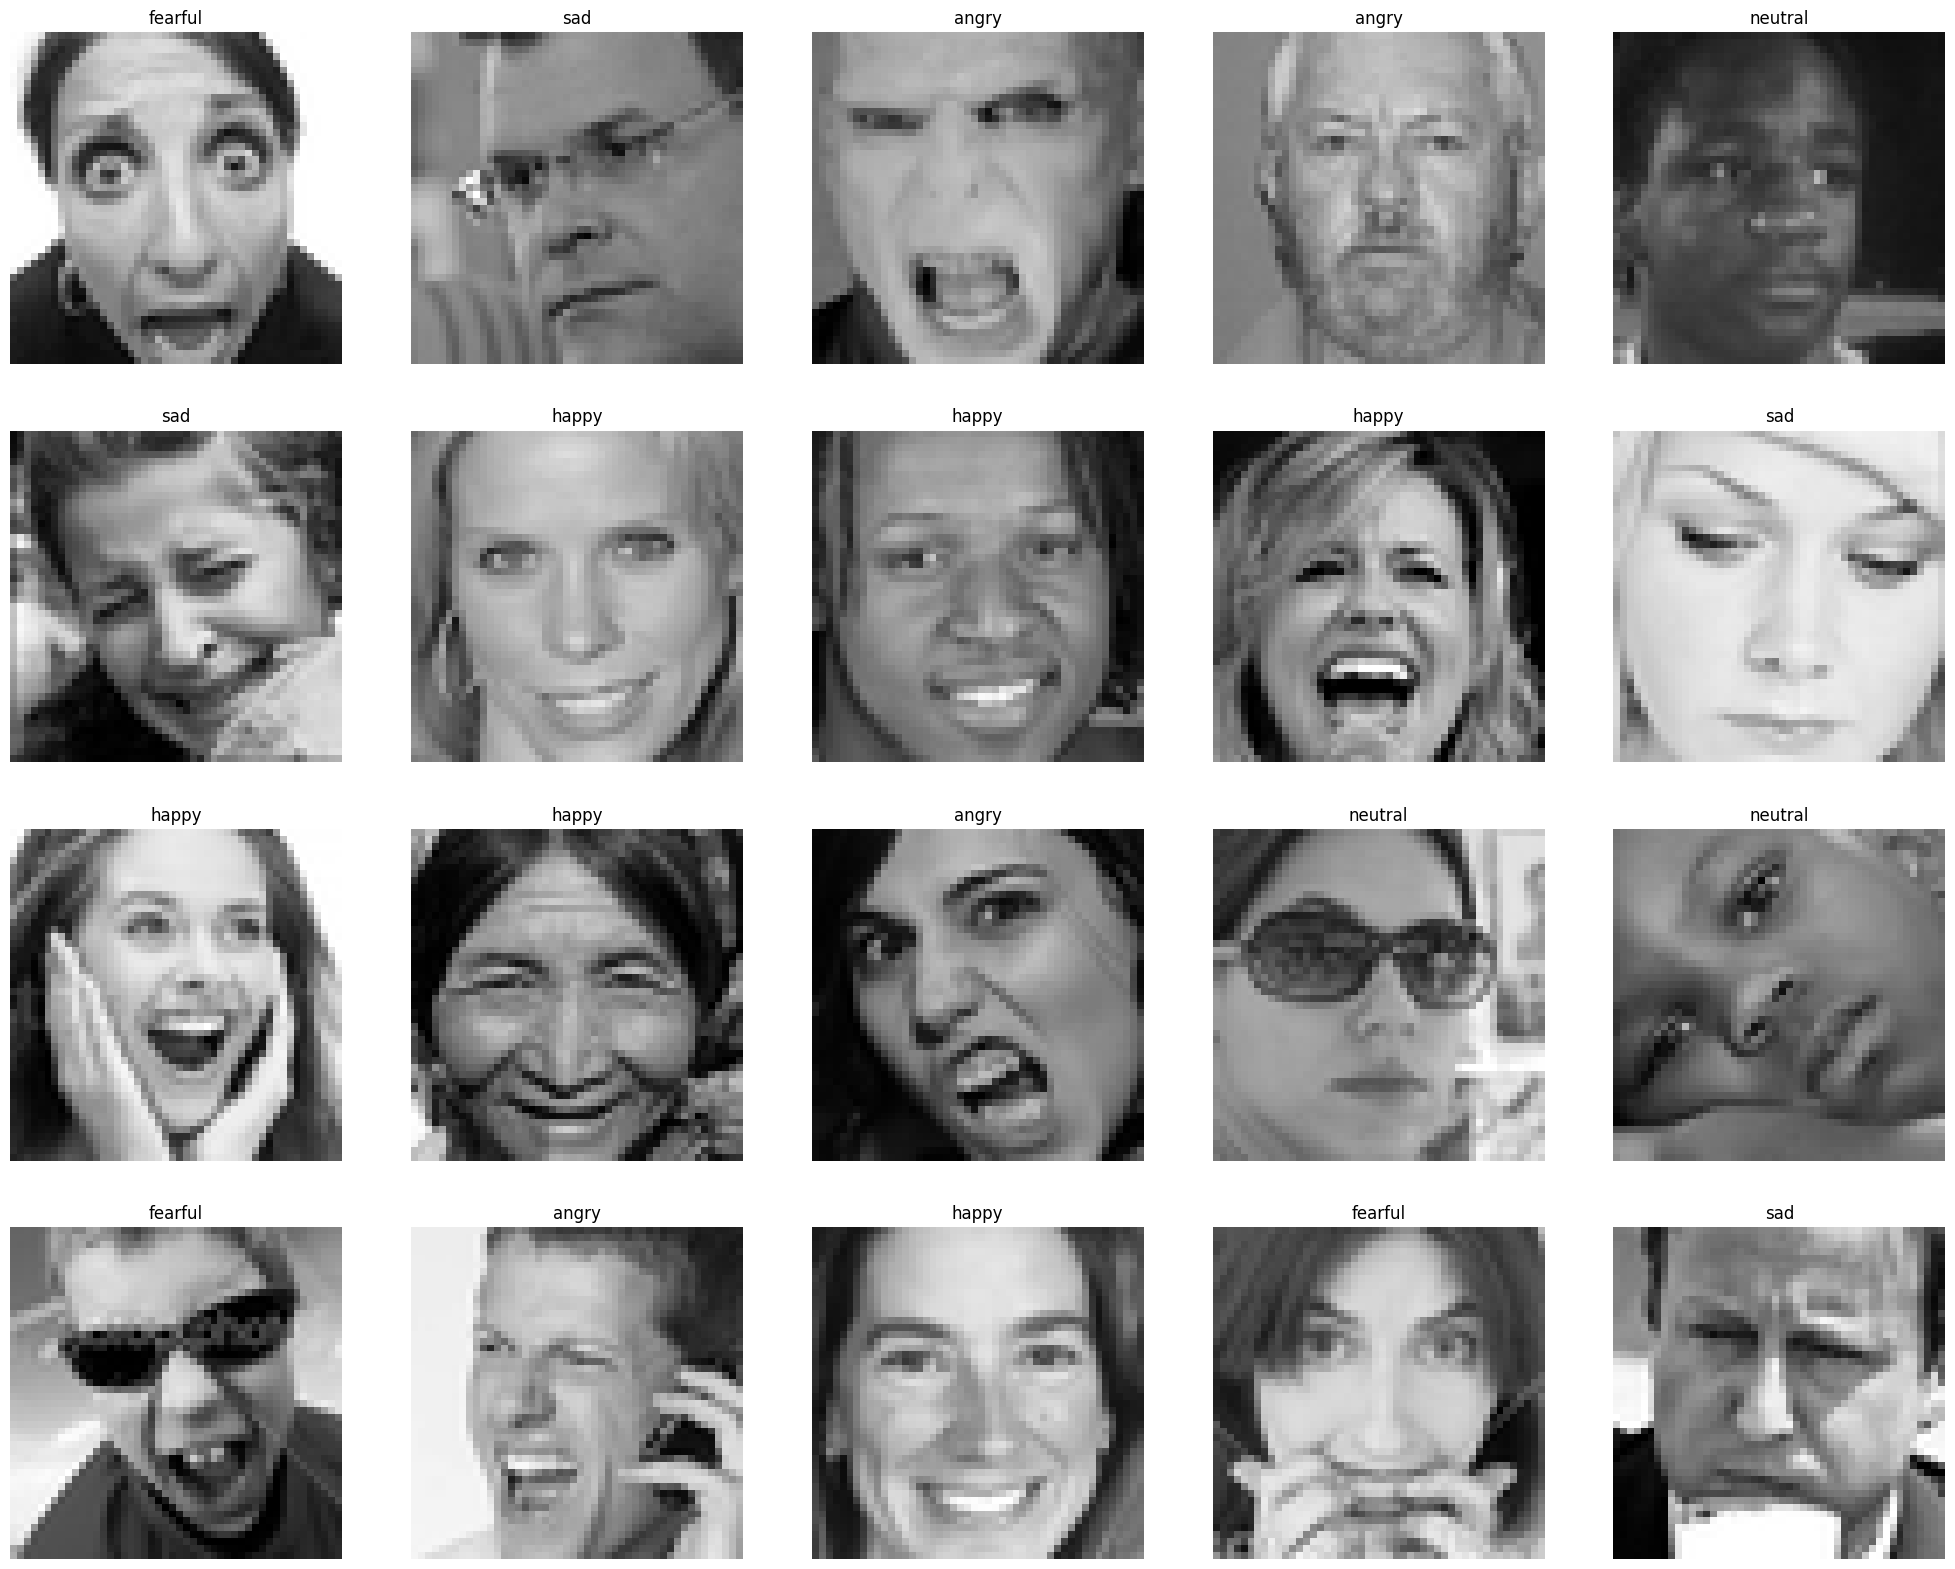

In [ ]:
plt.figure(figsize=(25,25))    # İlk 20 görüntüyü görselleştir
files = train.iloc[0:20]

for index, file , label in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [ ]:
def extract_özellik(images): # Görüntü özelliklerini çıkarmak için kullanılıcak fonksiyon
    özellik = []
    for image in tqdm(images):
        img = load_img(image,grayscale = True)
        img = np.array(img)
        özellik.append(img)
    özellik = np.array(özellik)
    özellik = özellik.reshape(len(özellik),48,48,1)
    return özellik


In [ ]:
train_özellik = extract_özellik(train["image"]) #Train veri setinden özellikleri çıkar

  0%|          | 0/28709 [00:00<?, ?it/s]

In [ ]:
test_özellik = extract_özellik(test["image"]) # Test veri setinden özellikleri çıkar

In [ ]:

x_train = train_özellik/255.0  # Görüntü verilerini normalize et
x_test = test_özellik/255.0


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["label"])
y_train = le.transform(train["label"]) #Train veri setlerinin etiketlerini kodla
y_test = le.transform(test["label"]) #Test veri setlerinin etiketlerini kodla

In [ ]:
y_train = to_categorical(y_train , num_classes = 7) # Etiketleri kategorik hale getir
y_test = to_categorical(y_test , num_classes = 7)

In [ ]:
y_train[1]

In [ ]:
input_shape = (48,48,1)
output_class = 7

In [ ]:
model = Sequential() # Keras Sequential modeli oluşturuluyor, bu modele sıralı katmanlar eklenecek.
# İlk Convoluion katmanı
model.add(Conv2D(128, kernel_size=(3,3),activation="relu",input_shape = input_shape))# 128 adet 3x3 filtre ile görüntü üzerinde Convolution işlemi yapılıyor.
# Aktivasyon fonksiyonu olarak ReLU kullanılıyor.
# İlk katmanda giriş şekli belirtiliyo
model.add(MaxPooling2D(pool_size=(2,2)))# MaxPooling2D katmanı, 2x2 boyutunda maksimum değeri alan bir havuzlama işlemi yapıyor.
# Bu işlem görüntü boyutunu yarıya indirir.
model.add(Dropout(0,4))# Dropout katmanı, ağırlıkların belirli bir yüzdesini rastgele sıfıra atar.
# Bu, aşırı uyumunu önlemek ve modelin genelleme yapmasını sağlamak için kullanılır.
# Burada %40 dropout uygulanıyor.

# Diğer Convolution, MaxPooling ve Dropout katmanları aynı şekilde tekrarlanıyor.
model.add(Conv2D(256, kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0,4))

model.add(Conv2D(512, kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0,4))

model.add(Conv2D(512, kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0,4))

model.add(Flatten()) # Flatten katmanı, 3 boyutlu verileri düzleştirerek bir vektör haline getirir.
# Bu, tam bağlantılı (fully connected) katmanlarda kullanılabilirlik için gereklidir.

model.add(Dense(512, activation = "relu"))# Dense katmanı, tam bağlantılı bir yapay sinir ağı katmanıdır.
# Bu katmanda 512 nöron bulunur ve ReLU aktivasyon fonksiyonu kullanılır
model.add(Dropout(0,4))
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0,3))


model.add(Dense(output_class, activation='softmax'))# Çıkış katmanı, sınıflandırma problemlerinde kullanılır.
# Bu örnekte 7 sınıf olduğu için 7 nöron bulunur ve softmax aktivasyon fonksiyonu kullanılır.
# Softmax fonksiyonu, sınıf olasılıklarını tahmin etmek için kullanılır.

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])# Model derleniyor.
# Optimizasyon algoritması olarak Adam kullanılıyor.
# Kayıp fonksiyonu olarak kategorik

In [ ]:
model.summary()


In [ ]:
geçmiş = model.fit(x=x_train,y=y_train, batch_size=128, epochs=100,validation_data=(x_test,y_test)) # Modeli eğit

In [ ]:

train_accuracy = geçmiş.history['accuracy']
val_accuracy = geçmiş.history['val_accuracy']
train_loss = geçmiş.history['loss']
val_loss = geçmiş.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Accuracy grafiği
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss grafiği
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import random
num_trials = 1  # Deneme sayısı

for _ in range(num_trials):
    image_index = random.randint(0, len(test))  # Rastgele bir görüntü indeksi seçilir
    print('Orjinal Output:', test['label'][image_index])

    pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
    prediction_label = le.inverse_transform([pred.argmax()])[0]
    print('Tahmini Output:', prediction_label)

    plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')
    plt.show()

In [ ]:
# Test verilerini dönüştürme
x_test = []

for image_path in test["image"]:
    image = Image.open(image_path).convert("L").resize((48, 48))
    image_array = np.array(image) / 255.0
    x_test.append(image_array)

x_test = np.array(x_test)
layer_index = 0
# Tahmin yapma
intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[layer_index].output[0])
intermediate_output = intermediate_layer_model.predict(x_test)

# Görselleştirmek istediğiniz örneği seçme
example_index = 0
prediction = intermediate_output[example_index]

# Özellik haritasını oluşturma
feature_map = np.squeeze(prediction)

# Görselleştirme
plt.imshow(feature_map, cmap='viridis')
plt.show()



